# Simulation of atmospheric transparency at CTIO

- according data in MERRA2
- libradtran


In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
from astropy.io import fits
import numpy as np
import pandas as pd

In [86]:
from astropy.io import fits

In [87]:
import libsimulateTranspCTIOScattAbsAer as atmsim

# Config

In [88]:
#  column 0 : count number
#  column 1 : aerosol value
#  column 2 : pwv value
#  column 3 : ozone value
#  column 6 : data start 
#
index_atm_count=0
index_atm_aer=1
index_atm_pwv=2
index_atm_oz=3
index_atm_ps=4
index_atm_cloud=5
index_atm_data=6

NB_atm_HEADER=6
#NB_atm_DATA=len(WL)-1

# output file

In [89]:
output_file='MERRA2_2017_M2I1NXASM_M2T1NXAER_M2T1NXRAD_ctio_atmsim.fits'

# input files : data logbook and Merra data

In [90]:
file_merra2='MERRA2_2017_M2I1NXASM_M2T1NXAER_M2T1NXRAD_ctio_AllYear.csv'
file_logbook_ctio='ctiofulllogbook_jun2017_v4.csv'

## Merra data

In [91]:
df_merra2=pd.read_csv(file_merra2,index_col=0)

In [92]:
df_merra2.index.name='time'
df_merra2.sort_index(inplace=True)

In [93]:
df_merra2.head()

,ps,pwv,ozone,TOTEXTTAU,TOTANGSTR,TOTSCATAU,TAUTOT,TAUHGH,TAUMID,TAULOW
time,,,,,,,,,,
2017-04-30 00:00:00,78636.914062,2.822547,260.352051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-30 00:30:00,NaN,NaN,NaN,0.029347,1.307469,0.027696,0.0,0.0,0.0,0.0
2017-04-30 01:00:00,78649.085938,2.668410,261.006653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-30 01:30:00,NaN,NaN,NaN,0.028410,1.303434,0.026786,0.0,0.0,0.0,0.0
2017-04-30 02:00:00,78661.726562,2.609197,261.566254,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## CTIO data

In [94]:
df_ctio=pd.read_csv(file_logbook_ctio,sep=';')

In [95]:
df_ctio.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [96]:
df_ctio=df_ctio.reindex(columns=['date','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','file']).set_index('date').sort_index()

In [97]:
df_ctio.head()

,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,file
date,,,,,,,,,,,,
2017-05-28T01:36:40.705,779,"5,6",60,"1,009","1,443",5,pointing,dia,Thor300,0,"8,9",reduc_20170526_001.fits
2017-05-28T01:41:52.197,780,"5,6",60,"1,007","1,39",5,pointing,dia,Ron400,0,"10,8",reduc_20170526_002.fits
2017-05-28T01:46:06.150,779,"5,9",59,"1,057","1,255",5,pointing,dia,Ron400,0,"6,8",reduc_20170526_003.fits
2017-05-28T01:50:31.257,779,"5,9",57,"1,057","1,409",5,pointing,dia,Ron400,0,"9,1",reduc_20170526_004.fits
2017-05-28T01:58:18.598,779,"5,9",0,"1,058","1,293",5,pointing,dia,Ron400,0,"14,7",reduc_20170526_005.fits


In [98]:
df_ctio.tail()

,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,file
date,,,,,,,,,,,,
2017-06-14T07:50:09.848,-4,-4,-4,"1,849","1,366",120,HD185975,RG715,HoloAmAg,12400,-4,reduc_20170613_095.fits
2017-06-14T07:53:38.102,-4,-4,-4,"1,027","1,366",60,HD205905,RG715,Thor300,12400,-4,reduc_20170613_096.fits
2017-06-14T07:55:30.851,-4,-4,-4,"1,025","1,366",60,HD205905,RG715,HoloPhP,12400,-4,reduc_20170613_097.fits
2017-06-14T07:57:24.265,-4,-4,-4,"1,023","1,366",120,HD205905,RG715,HoloPhAg,12400,-4,reduc_20170613_098.fits
2017-06-14T08:00:16.957,-4,-4,-4,"1,021","1,366",120,HD205905,RG715,HoloAmAg,12400,-4,reduc_20170613_099.fits


# Test LibRadTran

In [99]:
z_airmass=1.0
pwv=4.0
o3=300.
P=780.
aer=0.05

In [100]:
path,file=atmsim.ProcessSimulationaer(z_airmass,pwv,o3,aer,P) 

In [101]:
fullfilename=os.path.join(path,file)

In [102]:
data=np.loadtxt(fullfilename)

In [103]:
wl=data[:,0]

In [104]:
WL=wl
NB_atm_DATA=len(WL)

In [105]:
atm=data[:,1]

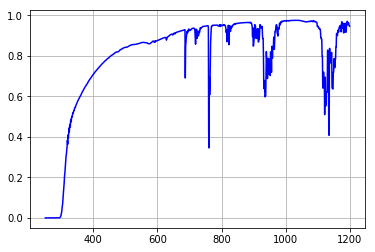

In [106]:
plt.plot(wl,atm,'b-')
plt.grid()

# Time

In [107]:
all_ctio_datetime=pd.to_datetime(df_ctio.index.get_values())

In [108]:
ctio_start_time=all_ctio_datetime[0]
ctio_stop_time=all_ctio_datetime[-1]
print 'CTIO :', ctio_start_time,' --> ', ctio_stop_time

CTIO : 2017-05-28 01:36:40.705000  -->  2017-06-14 08:00:16.957000


In [109]:
df_merra2.index.get_values()

array(['2017-04-30 00:00:00', '2017-04-30 00:30:00', '2017-04-30 01:00:00',
       ..., '2017-06-29 22:30:00', '2017-06-29 23:00:00',
       '2017-06-29 23:30:00'], dtype=object)

In [110]:
# convert the string into timestamp
#-------------------------------------
all_datetime=pd.to_datetime(df_merra2.index.get_values())

In [111]:
print len(all_datetime)

2928


# number of atmospheric simulation to perform

In [112]:
#NB_ATM_POINTS=np.sum(all_datetime.minute==0)
NB_ATM_POINTS=len(all_datetime)

In [113]:
print NB_ATM_POINTS

2928


# prepare the simulation grid

In [114]:
atmgrid=np.zeros((NB_ATM_POINTS+1,NB_atm_HEADER+NB_atm_DATA))
atmgrid[0,index_atm_data:]=WL # save the wavelength

In [115]:
idx=0
for timestamp in all_datetime:
    month=timestamp.month
    day=timestamp.days_in_month
    hour=timestamp.hour
    minu=timestamp.minute
    
    # goal take every hours pressure, PWV and Ozone, and average the aerosols and clouds 30 min before and 30 min after
    if minu==0:
        ps=df_merra2.iloc[idx]["ps"]/100. # in hecto-Pa
        pwv=df_merra2.iloc[idx]["pwv"]
        ozone=df_merra2.iloc[idx]["ozone"]
       
        deltat=(all_datetime-timestamp).total_seconds()
        idx_before=np.where(deltat==-1800)[0] # which is the index 1800 seconds before
        idx_after=np.where(deltat==1800)[0]   # which is the index 1800 seconds after
        if idx_before.size==0 and idx_after.size==1:
            aer=df_merra2.iloc[idx_after[0]]["TOTEXTTAU"]
            clouds=df_merra2.iloc[idx_after[0]]["TAUTOT"]
        elif idx_before.size==1 and idx_after.size==0:
            aer=df_merra2.iloc[idx_before[0]]["TOTEXTTAU"] 
            clouds=df_merra2.iloc[idx_before[0]]["TAUTOT"] 
        elif idx_before.size==1 and idx_after.size==1:
            aer=np.mean([df_merra2.iloc[idx_before[0]]["TOTEXTTAU"] ,df_merra2.iloc[idx_after[0]]["TOTEXTTAU"] ])
            clouds=np.mean([df_merra2.iloc[idx_before[0]]["TAUTOT"] ,df_merra2.iloc[idx_after[0]]["TAUTOT"] ])
        else:
            aer=0
            clouds=0
        
        if timestamp >= ctio_start_time and timestamp <= ctio_stop_time:
        
            print 'idx=',idx, ' timestamp=',timestamp,' P=',ps,' pwv=',pwv,' ozone =',ozone
            print ' \t aer=',aer, ' , clouds = ',clouds,' , : index before and after :', idx_before,' ',idx_after, idx_before.size, idx_after.size
        
    idx+=1  # increase the counter

idx= 1348  timestamp= 2017-05-28 02:00:00  P= 785.735625  pwv= 1.96106541157  ozone = 269.083740234
 	 aer= 0.0158923352138  , clouds =  7.93143262855e-05  , : index before and after : [1347]   [1349] 1 1
idx= 1350  timestamp= 2017-05-28 03:00:00  P= 785.7328125  pwv= 1.988093853  ozone = 269.268249512
 	 aer= 0.0167772537098  , clouds =  0.121386918341  , : index before and after : [1349]   [1351] 1 1
idx= 1352  timestamp= 2017-05-28 04:00:00  P= 785.457890625  pwv= 2.0557243824  ozone = 269.085266113
 	 aer= 0.0182545380667  , clouds =  0.613983415068  , : index before and after : [1351]   [1353] 1 1
idx= 1354  timestamp= 2017-05-28 05:00:00  P= 785.008828125  pwv= 2.15297675133  ozone = 268.995483398
 	 aer= 0.0201428718865  , clouds =  1.49511757493  , : index before and after : [1353]   [1355] 1 1
idx= 1356  timestamp= 2017-05-28 06:00:00  P= 784.731328125  pwv= 2.47634077072  ozone = 268.803314209
 	 aer= 0.0222689816728  , clouds =  1.74853551388  , : index before and after : [1

idx= 1446  timestamp= 2017-05-30 03:00:00  P= 785.619375  pwv= 4.84694957733  ozone = 282.488250732
 	 aer= 0.0279915966094  , clouds =  0.125915795565  , : index before and after : [1445]   [1447] 1 1
idx= 1448  timestamp= 2017-05-30 04:00:00  P= 785.6921875  pwv= 4.7390537262  ozone = 281.404846191
 	 aer= 0.0260222479701  , clouds =  0.0496523678303  , : index before and after : [1447]   [1449] 1 1
idx= 1450  timestamp= 2017-05-30 05:00:00  P= 785.724375  pwv= 4.61756896973  ozone = 280.692352295
 	 aer= 0.0235823122785  , clouds =  0.0  , : index before and after : [1449]   [1451] 1 1
idx= 1452  timestamp= 2017-05-30 06:00:00  P= 785.832734375  pwv= 4.57953977585  ozone = 279.38104248
 	 aer= 0.0217490280047  , clouds =  0.0  , : index before and after : [1451]   [1453] 1 1
idx= 1454  timestamp= 2017-05-30 07:00:00  P= 785.888359375  pwv= 4.57069063187  ozone = 277.358428955
 	 aer= 0.0203200951218  , clouds =  0.0  , : index before and after : [1453]   [1455] 1 1
idx= 1456  timest

 	 aer= 0.0131357032805  , clouds =  0.104923354462  , : index before and after : [1561]   [1563] 1 1
idx= 1564  timestamp= 2017-06-01 14:00:00  P= 787.221015625  pwv= 2.39819121361  ozone = 262.793060303
 	 aer= 0.0124803143554  , clouds =  0.00879293866455  , : index before and after : [1563]   [1565] 1 1
idx= 1566  timestamp= 2017-06-01 15:00:00  P= 787.50359375  pwv= 2.55123376846  ozone = 263.363891602
 	 aer= 0.0138332522474  , clouds =  0.0605469085275  , : index before and after : [1565]   [1567] 1 1
idx= 1568  timestamp= 2017-06-01 16:00:00  P= 787.260859375  pwv= 2.73503303528  ozone = 263.090209961
 	 aer= 0.015497835353  , clouds =  0.126556452363  , : index before and after : [1567]   [1569] 1 1
idx= 1570  timestamp= 2017-06-01 17:00:00  P= 786.772421875  pwv= 2.95944619179  ozone = 262.687286377
 	 aer= 0.0161105571315  , clouds =  0.131378203631  , : index before and after : [1569]   [1571] 1 1
idx= 1572  timestamp= 2017-06-01 18:00:00  P= 786.29421875  pwv= 3.2273287773

 	 aer= 0.0312055433169  , clouds =  1.61157238484  , : index before and after : [1671]   [1673] 1 1
idx= 1674  timestamp= 2017-06-03 21:00:00  P= 784.49109375  pwv= 5.00693082809  ozone = 258.22869873
 	 aer= 0.0295046269894  , clouds =  1.65307635069  , : index before and after : [1673]   [1675] 1 1
idx= 1676  timestamp= 2017-06-03 22:00:00  P= 784.407265625  pwv= 4.59662532806  ozone = 260.67980957
 	 aer= 0.0268927058205  , clouds =  1.58081060648  , : index before and after : [1675]   [1677] 1 1
idx= 1678  timestamp= 2017-06-03 23:00:00  P= 784.3425  pwv= 4.23715162277  ozone = 261.851074219
 	 aer= 0.0247438093647  , clouds =  1.7106935978  , : index before and after : [1677]   [1679] 1 1
idx= 1680  timestamp= 2017-06-04 00:00:00  P= 784.46140625  pwv= 4.00187730789  ozone = 262.80267334
 	 aer= 0.023854480125  , clouds =  2.16674840451  , : index before and after : [1679]   [1681] 1 1
idx= 1682  timestamp= 2017-06-04 01:00:00  P= 784.705546875  pwv= 3.78139519691  ozone = 263.76

idx= 1786  timestamp= 2017-06-06 05:00:00  P= 783.77515625  pwv= 3.82218575478  ozone = 294.652557373
 	 aer= 0.0234170351177  , clouds =  0.0  , : index before and after : [1785]   [1787] 1 1
idx= 1788  timestamp= 2017-06-06 06:00:00  P= 783.76  pwv= 3.97676753998  ozone = 293.933105469
 	 aer= 0.0262082749978  , clouds =  0.0  , : index before and after : [1787]   [1789] 1 1
idx= 1790  timestamp= 2017-06-06 07:00:00  P= 783.556875  pwv= 4.12356567383  ozone = 293.458374023
 	 aer= 0.0287102106959  , clouds =  0.0  , : index before and after : [1789]   [1791] 1 1
idx= 1792  timestamp= 2017-06-06 08:00:00  P= 783.2965625  pwv= 4.161901474  ozone = 293.370269775
 	 aer= 0.0298452703282  , clouds =  0.0  , : index before and after : [1791]   [1793] 1 1
idx= 1794  timestamp= 2017-06-06 09:00:00  P= 783.188828125  pwv= 4.0927939415  ozone = 293.339691162
 	 aer= 0.0296373507008  , clouds =  0.0  , : index before and after : [1793]   [1795] 1 1
idx= 1796  timestamp= 2017-06-06 10:00:00  P= 

idx= 1902  timestamp= 2017-06-08 15:00:00  P= 789.953359375  pwv= 4.51346492767  ozone = 282.447937012
 	 aer= 0.0143219125457  , clouds =  0.0  , : index before and after : [1901]   [1903] 1 1
idx= 1904  timestamp= 2017-06-08 16:00:00  P= 789.971640625  pwv= 4.79439115524  ozone = 282.737976074
 	 aer= 0.0125918318517  , clouds =  0.0  , : index before and after : [1903]   [1905] 1 1
idx= 1906  timestamp= 2017-06-08 17:00:00  P= 789.52640625  pwv= 5.18707990646  ozone = 283.218536377
 	 aer= 0.0118519784882  , clouds =  0.0  , : index before and after : [1905]   [1907] 1 1
idx= 1908  timestamp= 2017-06-08 18:00:00  P= 789.2396875  pwv= 5.76546382904  ozone = 282.526550293
 	 aer= 0.0137569773942  , clouds =  0.0  , : index before and after : [1907]   [1909] 1 1
idx= 1910  timestamp= 2017-06-08 19:00:00  P= 789.13328125  pwv= 6.44531917572  ozone = 279.770599365
 	 aer= 0.015546943061  , clouds =  0.00509836059065  , : index before and after : [1909]   [1911] 1 1
idx= 1912  timestamp= 

idx= 2022  timestamp= 2017-06-11 03:00:00  P= 784.84203125  pwv= 3.92588734627  ozone = 276.634490967
 	 aer= 0.0144934775308  , clouds =  0.0  , : index before and after : [2021]   [2023] 1 1
idx= 2024  timestamp= 2017-06-11 04:00:00  P= 784.9103125  pwv= 3.88989782333  ozone = 273.191986084
 	 aer= 0.0140992072411  , clouds =  0.0  , : index before and after : [2023]   [2025] 1 1
idx= 2026  timestamp= 2017-06-11 05:00:00  P= 784.900546875  pwv= 3.84826207161  ozone = 272.951721191
 	 aer= 0.0139317633584  , clouds =  0.0  , : index before and after : [2025]   [2027] 1 1
idx= 2028  timestamp= 2017-06-11 06:00:00  P= 784.937109375  pwv= 3.8295378685  ozone = 272.471008301
 	 aer= 0.0140775358304  , clouds =  0.0  , : index before and after : [2027]   [2029] 1 1
idx= 2030  timestamp= 2017-06-11 07:00:00  P= 784.872734375  pwv= 3.78305149078  ozone = 271.555908203
 	 aer= 0.0143074323423  , clouds =  0.0  , : index before and after : [2029]   [2031] 1 1
idx= 2032  timestamp= 2017-06-11 0

idx= 2134  timestamp= 2017-06-13 11:00:00  P= 785.41203125  pwv= 2.68390154839  ozone = 262.657989502
 	 aer= 0.0136625985615  , clouds =  0.0  , : index before and after : [2133]   [2135] 1 1
idx= 2136  timestamp= 2017-06-13 12:00:00  P= 785.64515625  pwv= 2.70025062561  ozone = 261.272216797
 	 aer= 0.0142529723235  , clouds =  0.0  , : index before and after : [2135]   [2137] 1 1
idx= 2138  timestamp= 2017-06-13 13:00:00  P= 785.704375  pwv= 2.7641017437  ozone = 260.058898926
 	 aer= 0.0157449645922  , clouds =  0.00594721967355  , : index before and after : [2137]   [2139] 1 1
idx= 2140  timestamp= 2017-06-13 14:00:00  P= 785.73359375  pwv= 2.89615321159  ozone = 259.123413086
 	 aer= 0.0181369828061  , clouds =  0.0275537264534  , : index before and after : [2139]   [2141] 1 1
idx= 2142  timestamp= 2017-06-13 15:00:00  P= 785.778515625  pwv= 2.95837211609  ozone = 259.346618652
 	 aer= 0.0217047175393  , clouds =  0.0563202742487  , : index before and after : [2141]   [2143] 1 1


# Do the simulation

In [116]:
idx=0
for timestamp in all_datetime:
    month=timestamp.month
    day=timestamp.days_in_month
    hour=timestamp.hour
    minu=timestamp.minute
    
    # goal take every hours pressure, PWV and Ozone, and average the aerosols and clouds 30 min before and 30 min after
    if minu==0:
        ps=df_merra2.iloc[idx]["ps"]/100. # in hecto-Pa
        pwv=df_merra2.iloc[idx]["pwv"]
        ozone=df_merra2.iloc[idx]["ozone"]
       
        deltat=(all_datetime-timestamp).total_seconds()
        idx_before=np.where(deltat==-1800)[0] # which is the index 1800 seconds before
        idx_after=np.where(deltat==1800)[0]   # which is the index 1800 seconds after
        if idx_before.size==0 and idx_after.size==1:
            aer=df_merra2.iloc[idx_after[0]]["TOTEXTTAU"]
            clouds=df_merra2.iloc[idx_after[0]]["TAUTOT"]
        elif idx_before.size==1 and idx_after.size==0:
            aer=df_merra2.iloc[idx_before[0]]["TOTEXTTAU"] 
            clouds=df_merra2.iloc[idx_before[0]]["TAUTOT"] 
        elif idx_before.size==1 and idx_after.size==1:
            aer=np.mean([df_merra2.iloc[idx_before[0]]["TOTEXTTAU"] ,df_merra2.iloc[idx_after[0]]["TOTEXTTAU"] ])
            clouds=np.mean([df_merra2.iloc[idx_before[0]]["TAUTOT"] ,df_merra2.iloc[idx_after[0]]["TAUTOT"] ])
        else:
            aer=0
            clouds=0
            
        print ' \t aer=',aer, ' , clouds = ',clouds,' , : index before and after :', idx_before,' ',idx_after, idx_before.size, idx_after.size
        
        # fills the header
        atmgrid[idx+1,index_atm_count]=idx+1 # simu number starting at 1
        atmgrid[idx+1,index_atm_aer]=aer     #  aerosols
        atmgrid[idx+1,index_atm_pwv]=pwv     # precipitable water vapor
        atmgrid[idx+1,index_atm_oz]=ozone    # Ozone
        atmgrid[idx+1,index_atm_ps]=ps        # Pressure
        atmgrid[idx+1,index_atm_cloud]=clouds  # Cloud
        
        if timestamp >= ctio_start_time and timestamp <= ctio_stop_time:
            print 'idx=',idx, ' timestamp=',timestamp,' P=',ps,' pwv=',pwv,' ozone =',ozone
            print ' \t aer=',aer, ' , clouds = ',clouds,' , : index before and after :', idx_before,' ',idx_after, idx_before.size, idx_after.size                
            path,file=atmsim.ProcessSimulationaer(z_airmass,pwv,ozone,aer,ps) 
            fullfilename=os.path.join(path,file)
            data=np.loadtxt(fullfilename)
            atm=data[:,1]
            atmgrid[idx+1,index_atm_data:]=atm
        
        
    idx+=1  # increase the counter

 	 aer= 0.0293471701443  , clouds =  0.0  , : index before and after : []   [1] 0 1
 	 aer= 0.0288784056902  , clouds =  0.0  , : index before and after : [1]   [3] 1 1
 	 aer= 0.0282445503399  , clouds =  0.0  , : index before and after : [3]   [5] 1 1
 	 aer= 0.0278896754607  , clouds =  0.0  , : index before and after : [5]   [7] 1 1
 	 aer= 0.0272771045566  , clouds =  0.0  , : index before and after : [7]   [9] 1 1
 	 aer= 0.0262918025255  , clouds =  0.0  , : index before and after : [9]   [11] 1 1
 	 aer= 0.025135088712  , clouds =  0.0  , : index before and after : [11]   [13] 1 1
 	 aer= 0.0239054709673  , clouds =  0.0  , : index before and after : [13]   [15] 1 1
 	 aer= 0.0225548874587  , clouds =  0.0  , : index before and after : [15]   [17] 1 1
 	 aer= 0.0210944227875  , clouds =  0.0  , : index before and after : [17]   [19] 1 1
 	 aer= 0.0197005206719  , clouds =  0.0  , : index before and after : [19]   [21] 1 1
 	 aer= 0.0186184644699  , clouds =  0.0  , : index befo

 	 aer= 0.0314821237699  , clouds =  0.0560074439272  , : index before and after : [229]   [231] 1 1
 	 aer= 0.0335147436709  , clouds =  0.065757798031  , : index before and after : [231]   [233] 1 1
 	 aer= 0.033448137343  , clouds =  0.0195117168478  , : index before and after : [233]   [235] 1 1
 	 aer= 0.0323275942355  , clouds =  0.00067471753573  , : index before and after : [235]   [237] 1 1
 	 aer= 0.0308863669634  , clouds =  0.0  , : index before and after : [237]   [239] 1 1
 	 aer= 0.0292132161557  , clouds =  0.0  , : index before and after : [239]   [241] 1 1
 	 aer= 0.0272180791944  , clouds =  0.0  , : index before and after : [241]   [243] 1 1
 	 aer= 0.0251503894105  , clouds =  0.0  , : index before and after : [243]   [245] 1 1
 	 aer= 0.02374618873  , clouds =  0.0  , : index before and after : [245]   [247] 1 1
 	 aer= 0.0230661146342  , clouds =  0.0  , : index before and after : [247]   [249] 1 1
 	 aer= 0.0223468812183  , clouds =  0.0  , : index before and af

 	 aer= 0.0294235218316  , clouds =  0.0073698516935  , : index before and after : [485]   [487] 1 1
 	 aer= 0.0289395330474  , clouds =  0.00116494065151  , : index before and after : [487]   [489] 1 1
 	 aer= 0.0291231321171  , clouds =  0.0  , : index before and after : [489]   [491] 1 1
 	 aer= 0.0299043860286  , clouds =  0.00079038157128  , : index before and after : [491]   [493] 1 1
 	 aer= 0.0303907515481  , clouds =  0.0232591291424  , : index before and after : [493]   [495] 1 1
 	 aer= 0.0302219660952  , clouds =  0.0728078354151  , : index before and after : [495]   [497] 1 1
 	 aer= 0.0305930189789  , clouds =  0.176803946495  , : index before and after : [497]   [499] 1 1
 	 aer= 0.0320939775557  , clouds =  0.321960672736  , : index before and after : [499]   [501] 1 1
 	 aer= 0.0335476547479  , clouds =  0.445373743772  , : index before and after : [501]   [503] 1 1
 	 aer= 0.0347367655485  , clouds =  0.452880874276  , : index before and after : [503]   [505] 1 1
 	 a

 	 aer= 0.0389965958893  , clouds =  0.557861924172  , : index before and after : [685]   [687] 1 1
 	 aer= 0.0414787642658  , clouds =  0.581787794828  , : index before and after : [687]   [689] 1 1
 	 aer= 0.0434711277485  , clouds =  1.06372117996  , : index before and after : [689]   [691] 1 1
 	 aer= 0.0428526736796  , clouds =  1.93847703934  , : index before and after : [691]   [693] 1 1
 	 aer= 0.0397931616753  , clouds =  1.89233410359  , : index before and after : [693]   [695] 1 1
 	 aer= 0.0377507321537  , clouds =  0.89422647655  , : index before and after : [695]   [697] 1 1
 	 aer= 0.0375254396349  , clouds =  0.526917383075  , : index before and after : [697]   [699] 1 1
 	 aer= 0.039034832269  , clouds =  1.5250248909  , : index before and after : [699]   [701] 1 1
 	 aer= 0.0469820443541  , clouds =  4.32812523842  , : index before and after : [701]   [703] 1 1
 	 aer= 0.0570364817977  , clouds =  8.00390648842  , : index before and after : [703]   [705] 1 1
 	 aer= 0

 	 aer= 0.0607333742082  , clouds =  42.578125  , : index before and after : [885]   [887] 1 1
 	 aer= 0.0562024544925  , clouds =  41.015625  , : index before and after : [887]   [889] 1 1
 	 aer= 0.0599665846676  , clouds =  39.0234375  , : index before and after : [889]   [891] 1 1
 	 aer= 0.053312279284  , clouds =  34.7265625  , : index before and after : [891]   [893] 1 1
 	 aer= 0.0471189841629  , clouds =  46.484375  , : index before and after : [893]   [895] 1 1
 	 aer= 0.0474864970893  , clouds =  71.9609375  , : index before and after : [895]   [897] 1 1
 	 aer= 0.047757267952  , clouds =  71.7109375  , : index before and after : [897]   [899] 1 1
 	 aer= 0.0527475420386  , clouds =  58.3125  , : index before and after : [899]   [901] 1 1
 	 aer= 0.0579938758165  , clouds =  55.4140625  , : index before and after : [901]   [903] 1 1
 	 aer= 0.046427026391  , clouds =  49.765625  , : index before and after : [903]   [905] 1 1
 	 aer= 0.0337867923081  , clouds =  46.6875  , : 

 	 aer= 0.0330005036667  , clouds =  1.46533209086  , : index before and after : [1085]   [1087] 1 1
 	 aer= 0.0374647434801  , clouds =  2.07568359375  , : index before and after : [1087]   [1089] 1 1
 	 aer= 0.0408439002931  , clouds =  2.3505859375  , : index before and after : [1089]   [1091] 1 1
 	 aer= 0.044193033129  , clouds =  2.09082049132  , : index before and after : [1091]   [1093] 1 1
 	 aer= 0.0436984747649  , clouds =  1.24987816811  , : index before and after : [1093]   [1095] 1 1
 	 aer= 0.0387116894126  , clouds =  0.453736059367  , : index before and after : [1095]   [1097] 1 1
 	 aer= 0.0355692971498  , clouds =  0.156266048551  , : index before and after : [1097]   [1099] 1 1
 	 aer= 0.0348447840661  , clouds =  0.0719606261701  , : index before and after : [1099]   [1101] 1 1
 	 aer= 0.0362790413201  , clouds =  0.491500949487  , : index before and after : [1101]   [1103] 1 1
 	 aer= 0.0367893781513  , clouds =  1.11218267679  , : index before and after : [1103] 

 	 aer= 0.040837854147  , clouds =  24.12109375  , : index before and after : [1285]   [1287] 1 1
 	 aer= 0.040135409683  , clouds =  30.15234375  , : index before and after : [1287]   [1289] 1 1
 	 aer= 0.0376936942339  , clouds =  23.05078125  , : index before and after : [1289]   [1291] 1 1
 	 aer= 0.0375890880823  , clouds =  7.7109375  , : index before and after : [1291]   [1293] 1 1
 	 aer= 0.0376922357828  , clouds =  0.00053944357205  , : index before and after : [1293]   [1295] 1 1
 	 aer= 0.037041561678  , clouds =  0.0457970156567  , : index before and after : [1295]   [1297] 1 1
 	 aer= 0.0374632347375  , clouds =  1.02816820517  , : index before and after : [1297]   [1299] 1 1
 	 aer= 0.0387379620224  , clouds =  9.11572313308  , : index before and after : [1299]   [1301] 1 1
 	 aer= 0.0396593119949  , clouds =  18.16796875  , : index before and after : [1301]   [1303] 1 1
 	 aer= 0.0391606893391  , clouds =  15.6679692268  , : index before and after : [1303]   [1305] 1 1


 	 aer= 0.0320691717788  , clouds =  0.078369177878  , : index before and after : [1383]   [1385] 1 1
idx= 1384  timestamp= 2017-05-28 20:00:00  P= 784.49296875  pwv= 5.9449095726  ozone = 271.070281982
 	 aer= 0.0320691717788  , clouds =  0.078369177878  , : index before and after : [1383]   [1385] 1 1
 	 aer= 0.033707363531  , clouds =  0.270874090493  , : index before and after : [1385]   [1387] 1 1
idx= 1386  timestamp= 2017-05-28 21:00:00  P= 784.64453125  pwv= 6.05238580704  ozone = 272.831207275
 	 aer= 0.033707363531  , clouds =  0.270874090493  , : index before and after : [1385]   [1387] 1 1
 	 aer= 0.0324320495129  , clouds =  0.332763746381  , : index before and after : [1387]   [1389] 1 1
idx= 1388  timestamp= 2017-05-28 22:00:00  P= 784.7953125  pwv= 5.73046398163  ozone = 273.557525635
 	 aer= 0.0324320495129  , clouds =  0.332763746381  , : index before and after : [1387]   [1389] 1 1
 	 aer= 0.0291532818228  , clouds =  0.260040618479  , : index before and after : [138

 	 aer= 0.0332523258403  , clouds =  0.0  , : index before and after : [1439]   [1441] 1 1
idx= 1440  timestamp= 2017-05-30 00:00:00  P= 785.175078125  pwv= 5.40496921539  ozone = 285.5519104
 	 aer= 0.0332523258403  , clouds =  0.0  , : index before and after : [1439]   [1441] 1 1
 	 aer= 0.029973378405  , clouds =  0.0114555805921  , : index before and after : [1441]   [1443] 1 1
idx= 1442  timestamp= 2017-05-30 01:00:00  P= 785.259453125  pwv= 5.01527786255  ozone = 285.374511719
 	 aer= 0.029973378405  , clouds =  0.0114555805921  , : index before and after : [1441]   [1443] 1 1
 	 aer= 0.0287933880463  , clouds =  0.0877190083266  , : index before and after : [1443]   [1445] 1 1
idx= 1444  timestamp= 2017-05-30 02:00:00  P= 785.41515625  pwv= 4.86892414093  ozone = 284.185974121
 	 aer= 0.0287933880463  , clouds =  0.0877190083266  , : index before and after : [1443]   [1445] 1 1
 	 aer= 0.0279915966094  , clouds =  0.125915795565  , : index before and after : [1445]   [1447] 1 1


 	 aer= 0.0245453706011  , clouds =  0.0  , : index before and after : [1497]   [1499] 1 1
idx= 1498  timestamp= 2017-05-31 05:00:00  P= 788.678984375  pwv= 4.9020113945  ozone = 258.794769287
 	 aer= 0.0245453706011  , clouds =  0.0  , : index before and after : [1497]   [1499] 1 1
 	 aer= 0.0239672372118  , clouds =  0.0  , : index before and after : [1499]   [1501] 1 1
idx= 1500  timestamp= 2017-05-31 06:00:00  P= 788.67703125  pwv= 4.76629829407  ozone = 259.804382324
 	 aer= 0.0239672372118  , clouds =  0.0  , : index before and after : [1499]   [1501] 1 1
 	 aer= 0.0230709593743  , clouds =  0.0  , : index before and after : [1501]   [1503] 1 1
idx= 1502  timestamp= 2017-05-31 07:00:00  P= 788.408125  pwv= 4.5523557663  ozone = 261.27734375
 	 aer= 0.0230709593743  , clouds =  0.0  , : index before and after : [1501]   [1503] 1 1
 	 aer= 0.0218594241887  , clouds =  0.0  , : index before and after : [1503]   [1505] 1 1
idx= 1504  timestamp= 2017-05-31 08:00:00  P= 788.0059375  pw

 	 aer= 0.0129611701704  , clouds =  0.0708675719796  , : index before and after : [1555]   [1557] 1 1
idx= 1556  timestamp= 2017-06-01 10:00:00  P= 786.48890625  pwv= 2.45479750633  ozone = 257.581970215
 	 aer= 0.0129611701704  , clouds =  0.0708675719796  , : index before and after : [1555]   [1557] 1 1
 	 aer= 0.0137333711609  , clouds =  0.206512488424  , : index before and after : [1557]   [1559] 1 1
idx= 1558  timestamp= 2017-06-01 11:00:00  P= 786.64328125  pwv= 2.45410656929  ozone = 258.470184326
 	 aer= 0.0137333711609  , clouds =  0.206512488424  , : index before and after : [1557]   [1559] 1 1
 	 aer= 0.0138617628254  , clouds =  0.23638921976  , : index before and after : [1559]   [1561] 1 1
idx= 1560  timestamp= 2017-06-01 12:00:00  P= 786.812265625  pwv= 2.42763519287  ozone = 259.495300293
 	 aer= 0.0138617628254  , clouds =  0.23638921976  , : index before and after : [1559]   [1561] 1 1
 	 aer= 0.0131357032805  , clouds =  0.104923354462  , : index before and after :

 	 aer= 0.0187870236113  , clouds =  0.816772520542  , : index before and after : [1609]   [1611] 1 1
idx= 1610  timestamp= 2017-06-02 13:00:00  P= 784.9959375  pwv= 3.09132313728  ozone = 254.624145508
 	 aer= 0.0187870236113  , clouds =  0.816772520542  , : index before and after : [1609]   [1611] 1 1
 	 aer= 0.0170120736584  , clouds =  0.493591427803  , : index before and after : [1611]   [1613] 1 1
idx= 1612  timestamp= 2017-06-02 14:00:00  P= 785.384453125  pwv= 3.09853935242  ozone = 254.891784668
 	 aer= 0.0170120736584  , clouds =  0.493591427803  , : index before and after : [1611]   [1613] 1 1
 	 aer= 0.0179106965661  , clouds =  0.151306271553  , : index before and after : [1613]   [1615] 1 1
idx= 1614  timestamp= 2017-06-02 15:00:00  P= 785.560859375  pwv= 3.1668150425  ozone = 255.062988281
 	 aer= 0.0179106965661  , clouds =  0.151306271553  , : index before and after : [1613]   [1615] 1 1
 	 aer= 0.0203721746803  , clouds =  0.0  , : index before and after : [1615]   [1

 	 aer= 0.0307630039752  , clouds =  0.836548089982  , : index before and after : [1663]   [1665] 1 1
idx= 1664  timestamp= 2017-06-03 16:00:00  P= 785.445859375  pwv= 6.68868589401  ozone = 259.515380859
 	 aer= 0.0307630039752  , clouds =  0.836548089982  , : index before and after : [1663]   [1665] 1 1
 	 aer= 0.0327563788742  , clouds =  1.29931646586  , : index before and after : [1665]   [1667] 1 1
idx= 1666  timestamp= 2017-06-03 17:00:00  P= 785.239140625  pwv= 6.37523794174  ozone = 258.63949585
 	 aer= 0.0327563788742  , clouds =  1.29931646586  , : index before and after : [1665]   [1667] 1 1
 	 aer= 0.0334336105734  , clouds =  1.6982421875  , : index before and after : [1667]   [1669] 1 1
idx= 1668  timestamp= 2017-06-03 18:00:00  P= 784.924375  pwv= 6.0480761528  ozone = 258.332397461
 	 aer= 0.0334336105734  , clouds =  1.6982421875  , : index before and after : [1667]   [1669] 1 1
 	 aer= 0.0324058774858  , clouds =  1.681640625  , : index before and after : [1669]   [1

 	 aer= 0.0314066680148  , clouds =  3.67627000809  , : index before and after : [1717]   [1719] 1 1
idx= 1718  timestamp= 2017-06-04 19:00:00  P= 782.8796875  pwv= 4.26542568207  ozone = 279.353851318
 	 aer= 0.0314066680148  , clouds =  3.67627000809  , : index before and after : [1717]   [1719] 1 1
 	 aer= 0.0309783397243  , clouds =  3.88037145138  , : index before and after : [1719]   [1721] 1 1
idx= 1720  timestamp= 2017-06-04 20:00:00  P= 782.86953125  pwv= 4.28199386597  ozone = 279.054656982
 	 aer= 0.0309783397243  , clouds =  3.88037145138  , : index before and after : [1719]   [1721] 1 1
 	 aer= 0.0289796441793  , clouds =  3.39404320717  , : index before and after : [1721]   [1723] 1 1
idx= 1722  timestamp= 2017-06-04 21:00:00  P= 783.01453125  pwv= 4.14153337479  ozone = 279.041473389
 	 aer= 0.0289796441793  , clouds =  3.39404320717  , : index before and after : [1721]   [1723] 1 1
 	 aer= 0.0262984205037  , clouds =  2.21240270138  , : index before and after : [1723]  

 	 aer= 0.0283614210784  , clouds =  0.000111794681289  , : index before and after : [1773]   [1775] 1 1
idx= 1774  timestamp= 2017-06-05 23:00:00  P= 783.373671875  pwv= 4.35238027573  ozone = 292.878692627
 	 aer= 0.0283614210784  , clouds =  0.000111794681289  , : index before and after : [1773]   [1775] 1 1
 	 aer= 0.025560031645  , clouds =  0.000111794681289  , : index before and after : [1775]   [1777] 1 1
idx= 1776  timestamp= 2017-06-06 00:00:00  P= 783.648046875  pwv= 4.2691488266  ozone = 294.324401855
 	 aer= 0.025560031645  , clouds =  0.000111794681289  , : index before and after : [1775]   [1777] 1 1
 	 aer= 0.0234799422324  , clouds =  0.0  , : index before and after : [1777]   [1779] 1 1
idx= 1778  timestamp= 2017-06-06 01:00:00  P= 783.81046875  pwv= 4.13121747971  ozone = 295.555236816
 	 aer= 0.0234799422324  , clouds =  0.0  , : index before and after : [1777]   [1779] 1 1
 	 aer= 0.0219711177051  , clouds =  0.0  , : index before and after : [1779]   [1781] 1 1
id

 	 aer= 0.029249372892  , clouds =  0.0  , : index before and after : [1831]   [1833] 1 1
idx= 1832  timestamp= 2017-06-07 04:00:00  P= 782.17734375  pwv= 4.74815368652  ozone = 285.620269775
 	 aer= 0.029249372892  , clouds =  0.0  , : index before and after : [1831]   [1833] 1 1
 	 aer= 0.0319510446861  , clouds =  0.0  , : index before and after : [1833]   [1835] 1 1
idx= 1834  timestamp= 2017-06-07 05:00:00  P= 782.35609375  pwv= 5.06238174438  ozone = 286.791809082
 	 aer= 0.0319510446861  , clouds =  0.0  , : index before and after : [1833]   [1835] 1 1
 	 aer= 0.0373500864953  , clouds =  0.0  , : index before and after : [1835]   [1837] 1 1
idx= 1836  timestamp= 2017-06-07 06:00:00  P= 782.41109375  pwv= 5.66369771957  ozone = 287.333587646
 	 aer= 0.0373500864953  , clouds =  0.0  , : index before and after : [1835]   [1837] 1 1
 	 aer= 0.0438633505255  , clouds =  0.0  , : index before and after : [1837]   [1839] 1 1
idx= 1838  timestamp= 2017-06-07 07:00:00  P= 782.36609375 

 	 aer= 0.0336988046765  , clouds =  1.29418981075  , : index before and after : [1887]   [1889] 1 1
idx= 1888  timestamp= 2017-06-08 08:00:00  P= 788.6790625  pwv= 6.08761501312  ozone = 300.274475098
 	 aer= 0.0336988046765  , clouds =  1.29418981075  , : index before and after : [1887]   [1889] 1 1
 	 aer= 0.0294298464433  , clouds =  1.03320324421  , : index before and after : [1889]   [1891] 1 1
idx= 1890  timestamp= 2017-06-08 09:00:00  P= 788.651015625  pwv= 5.67998600006  ozone = 301.476959229
 	 aer= 0.0294298464433  , clouds =  1.03320324421  , : index before and after : [1889]   [1891] 1 1
 	 aer= 0.0249106660485  , clouds =  0.625854730607  , : index before and after : [1891]   [1893] 1 1
idx= 1892  timestamp= 2017-06-08 10:00:00  P= 788.393359375  pwv= 5.01852560043  ozone = 300.162475586
 	 aer= 0.0249106660485  , clouds =  0.625854730607  , : index before and after : [1891]   [1893] 1 1
 	 aer= 0.0214744564146  , clouds =  0.125122189522  , : index before and after : [18

 	 aer= 0.00799996731802  , clouds =  0.0  , : index before and after : [1943]   [1945] 1 1
idx= 1944  timestamp= 2017-06-09 12:00:00  P= 788.584765625  pwv= 5.6973991394  ozone = 268.02154541
 	 aer= 0.00799996731802  , clouds =  0.0  , : index before and after : [1943]   [1945] 1 1
 	 aer= 0.00821949634701  , clouds =  0.0  , : index before and after : [1945]   [1947] 1 1
idx= 1946  timestamp= 2017-06-09 13:00:00  P= 788.699765625  pwv= 5.30835056305  ozone = 266.989074707
 	 aer= 0.00821949634701  , clouds =  0.0  , : index before and after : [1945]   [1947] 1 1
 	 aer= 0.00857166992501  , clouds =  0.0  , : index before and after : [1947]   [1949] 1 1
idx= 1948  timestamp= 2017-06-09 14:00:00  P= 788.84484375  pwv= 5.00918388367  ozone = 265.725341797
 	 aer= 0.00857166992501  , clouds =  0.0  , : index before and after : [1947]   [1949] 1 1
 	 aer= 0.0109370080754  , clouds =  0.0  , : index before and after : [1949]   [1951] 1 1
idx= 1950  timestamp= 2017-06-09 15:00:00  P= 788.8

 	 aer= 0.012587683741  , clouds =  0.0  , : index before and after : [2001]   [2003] 1 1
idx= 2002  timestamp= 2017-06-10 17:00:00  P= 785.14375  pwv= 3.30408668518  ozone = 277.89855957
 	 aer= 0.012587683741  , clouds =  0.0  , : index before and after : [2001]   [2003] 1 1
 	 aer= 0.0140611985699  , clouds =  0.0  , : index before and after : [2003]   [2005] 1 1
idx= 2004  timestamp= 2017-06-10 18:00:00  P= 784.598203125  pwv= 3.6003818512  ozone = 276.835296631
 	 aer= 0.0140611985699  , clouds =  0.0  , : index before and after : [2003]   [2005] 1 1
 	 aer= 0.0158163681627  , clouds =  0.0  , : index before and after : [2005]   [2007] 1 1
idx= 2006  timestamp= 2017-06-10 19:00:00  P= 784.325390625  pwv= 3.91782474518  ozone = 275.746032715
 	 aer= 0.0158163681627  , clouds =  0.0  , : index before and after : [2005]   [2007] 1 1
 	 aer= 0.0174149954691  , clouds =  0.0  , : index before and after : [2007]   [2009] 1 1
idx= 2008  timestamp= 2017-06-10 20:00:00  P= 784.174609375  p

 	 aer= 0.0248200548813  , clouds =  0.0  , : index before and after : [2059]   [2061] 1 1
idx= 2060  timestamp= 2017-06-11 22:00:00  P= 785.776796875  pwv= 4.41306734085  ozone = 268.764526367
 	 aer= 0.0248200548813  , clouds =  0.0  , : index before and after : [2059]   [2061] 1 1
 	 aer= 0.0230117822066  , clouds =  0.0  , : index before and after : [2061]   [2063] 1 1
idx= 2062  timestamp= 2017-06-11 23:00:00  P= 786.01234375  pwv= 4.11043405533  ozone = 267.73739624
 	 aer= 0.0230117822066  , clouds =  0.0  , : index before and after : [2061]   [2063] 1 1
 	 aer= 0.0216183885932  , clouds =  0.0  , : index before and after : [2063]   [2065] 1 1
idx= 2064  timestamp= 2017-06-12 00:00:00  P= 786.26671875  pwv= 3.88524889946  ozone = 266.394958496
 	 aer= 0.0216183885932  , clouds =  0.0  , : index before and after : [2063]   [2065] 1 1
 	 aer= 0.0208545774222  , clouds =  0.0  , : index before and after : [2065]   [2067] 1 1
idx= 2066  timestamp= 2017-06-12 01:00:00  P= 786.4600781

 	 aer= 0.0184514271096  , clouds =  0.0  , : index before and after : [2117]   [2119] 1 1
idx= 2118  timestamp= 2017-06-13 03:00:00  P= 786.248359375  pwv= 4.2283782959  ozone = 270.169067383
 	 aer= 0.0184514271096  , clouds =  0.0  , : index before and after : [2117]   [2119] 1 1
 	 aer= 0.0175322461873  , clouds =  0.0  , : index before and after : [2119]   [2121] 1 1
idx= 2120  timestamp= 2017-06-13 04:00:00  P= 786.383984375  pwv= 4.07632541656  ozone = 268.450073242
 	 aer= 0.0175322461873  , clouds =  0.0  , : index before and after : [2119]   [2121] 1 1
 	 aer= 0.0166476108133  , clouds =  0.0  , : index before and after : [2121]   [2123] 1 1
idx= 2122  timestamp= 2017-06-13 05:00:00  P= 786.371640625  pwv= 3.84755063057  ozone = 267.078216553
 	 aer= 0.0166476108133  , clouds =  0.0  , : index before and after : [2121]   [2123] 1 1
 	 aer= 0.0153300403617  , clouds =  0.0  , : index before and after : [2123]   [2125] 1 1
idx= 2124  timestamp= 2017-06-13 06:00:00  P= 786.28023

 	 aer= 0.0332482308149  , clouds =  2.8935546875  , : index before and after : [2173]   [2175] 1 1
idx= 2174  timestamp= 2017-06-14 07:00:00  P= 784.23484375  pwv= 3.39551544189  ozone = 252.188140869
 	 aer= 0.0332482308149  , clouds =  2.8935546875  , : index before and after : [2173]   [2175] 1 1
 	 aer= 0.0335442088545  , clouds =  3.47412121296  , : index before and after : [2175]   [2177] 1 1
idx= 2176  timestamp= 2017-06-14 08:00:00  P= 783.9359375  pwv= 3.25969004631  ozone = 252.877227783
 	 aer= 0.0335442088545  , clouds =  3.47412121296  , : index before and after : [2175]   [2177] 1 1
 	 aer= 0.0334023777396  , clouds =  3.25732457638  , : index before and after : [2177]   [2179] 1 1
 	 aer= 0.0342800989747  , clouds =  3.04101598263  , : index before and after : [2179]   [2181] 1 1
 	 aer= 0.0358914770186  , clouds =  3.27343761921  , : index before and after : [2181]   [2183] 1 1
 	 aer= 0.0370480120182  , clouds =  3.67578136921  , : index before and after : [2183]   [2

 	 aer= 0.0187509767711  , clouds =  0.530792556703  , : index before and after : [2383]   [2385] 1 1
 	 aer= 0.0204439973458  , clouds =  1.05566418171  , : index before and after : [2385]   [2387] 1 1
 	 aer= 0.0216048136354  , clouds =  1.08435064554  , : index before and after : [2387]   [2389] 1 1
 	 aer= 0.0215883599595  , clouds =  0.691589385271  , : index before and after : [2389]   [2391] 1 1
 	 aer= 0.0204416429624  , clouds =  0.299286037683  , : index before and after : [2391]   [2393] 1 1
 	 aer= 0.0186253990978  , clouds =  0.0753480196  , : index before and after : [2393]   [2395] 1 1
 	 aer= 0.016571465414  , clouds =  0.0  , : index before and after : [2395]   [2397] 1 1
 	 aer= 0.0144855440594  , clouds =  0.0  , : index before and after : [2397]   [2399] 1 1
 	 aer= 0.0129183335229  , clouds =  0.0  , : index before and after : [2399]   [2401] 1 1
 	 aer= 0.0120757101103  , clouds =  0.0  , : index before and after : [2401]   [2403] 1 1
 	 aer= 0.0116596575827  , cl

 	 aer= 0.0521959364414  , clouds =  17.3671875  , : index before and after : [2583]   [2585] 1 1
 	 aer= 0.0506270993501  , clouds =  19.64453125  , : index before and after : [2585]   [2587] 1 1
 	 aer= 0.0471827611327  , clouds =  17.2421875  , : index before and after : [2587]   [2589] 1 1
 	 aer= 0.0417171511799  , clouds =  12.83984375  , : index before and after : [2589]   [2591] 1 1
 	 aer= 0.0360381174832  , clouds =  9.998046875  , : index before and after : [2591]   [2593] 1 1
 	 aer= 0.0319630345329  , clouds =  7.66796875  , : index before and after : [2593]   [2595] 1 1
 	 aer= 0.0308179585263  , clouds =  6.14257836342  , : index before and after : [2595]   [2597] 1 1
 	 aer= 0.0322775878012  , clouds =  6.18066453934  , : index before and after : [2597]   [2599] 1 1
 	 aer= 0.0336532834917  , clouds =  6.47851586342  , : index before and after : [2599]   [2601] 1 1
 	 aer= 0.0353950280696  , clouds =  6.11132836342  , : index before and after : [2601]   [2603] 1 1
 	 ae

 	 aer= 0.0301553113386  , clouds =  50.2109375  , : index before and after : [2783]   [2785] 1 1
 	 aer= 0.0383516140282  , clouds =  52.5703125  , : index before and after : [2785]   [2787] 1 1
 	 aer= 0.0324515225365  , clouds =  50.03125  , : index before and after : [2787]   [2789] 1 1
 	 aer= 0.034264431335  , clouds =  47.25  , : index before and after : [2789]   [2791] 1 1
 	 aer= 0.0371501222253  , clouds =  42.15625  , : index before and after : [2791]   [2793] 1 1
 	 aer= 0.0299594830722  , clouds =  36.453125  , : index before and after : [2793]   [2795] 1 1
 	 aer= 0.0244995476678  , clouds =  30.6953125  , : index before and after : [2795]   [2797] 1 1
 	 aer= 0.0223428579048  , clouds =  33.078125  , : index before and after : [2797]   [2799] 1 1
 	 aer= 0.0210550874472  , clouds =  39.3984375  , : index before and after : [2799]   [2801] 1 1
 	 aer= 0.019685302861  , clouds =  40.5546875  , : index before and after : [2801]   [2803] 1 1
 	 aer= 0.018422819674  , clouds 

In [117]:
def plot_transm_img():
    plt.figure()
    img=plt.imshow(atmgrid[1:,index_atm_data:],origin='lower',cmap='jet')
    plt.grid(True)
    plt.xlabel("$\lambda$ [nm]")
    plt.ylabel("Simulation number")
    plt.title(" Atmospheric transparency MERRA2")
    cbar=plt.colorbar(img)
    cbar.set_label('Atmospheric transmission')
    plt.show()

In [118]:
def savefile(filename=output_file):
             
    hdr = fits.Header()
                   
    hdr['ATMSIM'] = "libradtran"
    hdr['SIMVERS'] = "2.0.1"
    hdr['ATMDAT'] = " MERRA-2"
    hdr['ATMFIL'] = file_merra2
    hdr['AIRMASS'] = z_airmass

    
    hdr['IDX_CNT']=index_atm_count
    hdr['IDX_AER']=index_atm_aer
    hdr['IDX_PWV']=index_atm_pwv
    hdr['IDX_OZ']=index_atm_oz
    hdr['IDX_PS']=index_atm_ps
    hdr['IDX_CLD']=index_atm_cloud
    hdr['IDX_DATA']=index_atm_data
                
    print hdr
    
    hdu = fits.PrimaryHDU(atmgrid,header=hdr)
    hdu.writeto(filename,overwrite=True)


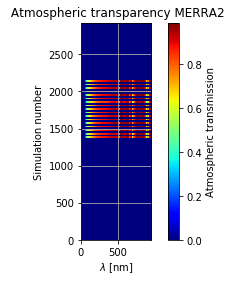

In [119]:
plot_transm_img()

In [120]:
savefile()

ATMSIM  = 'libradtran'                                                          SIMVERS = '2.0.1   '                                                            ATMDAT  = ' MERRA-2'                                                            ATMFIL  = 'MERRA2_2017_M2I1NXASM_M2T1NXAER_M2T1NXRAD_ctio_AllYear.csv'          AIRMASS =                  1.0                                                  IDX_CNT =                    0                                                  IDX_AER =                    1                                                  IDX_PWV =                    2                                                  IDX_OZ  =                    3                                                  IDX_PS  =                    4                                                  IDX_CLD =                    5                                                  IDX_DATA=                    6                                                  END                                     